# Case Study of Traffic Prediction (Demand Prediction)
## Import packages and functions

In [1]:
import pandas as pd  
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_metric(y_true, y_pred, mask_value=5):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true[np.where(y_true > mask_value)[0]], y_pred[np.where(y_true > mask_value)[0]])
    return mae, rmse, mape
  
def calculate_metric_torch(true, pred, mask_value=5):
    mae = torch.mean(torch.abs(true - pred))
    rmse = torch.sqrt(torch.mean((pred - true) ** 2))
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    mape = torch.mean(torch.abs(torch.div((true - pred), true))) * 100
    return mae, rmse, mape


## Load demand data
In this tutorial we use the taxi demand data aggregated every 30 minutes in 63 regions of Manhattan from Jan-1-2019 to June-30-2019. The data has been organized into a Numpy array with shape $63\times 8688$. You can access the data by using `numpy.load()`.

For demonstration purposes, we only use the first region's data as dataset to run quickly. You can retrain the model on the full dataset after class.

Text(0, 0.5, 'Demand')

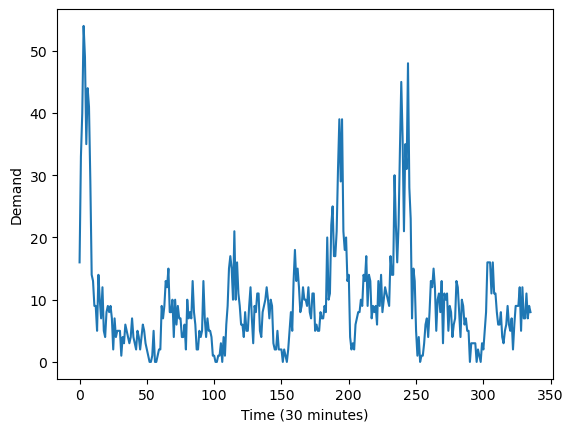

In [2]:
demand = np.load('./10min_demand_in_manhattan.npy')
demand = demand[0, :].reshape(1, -1)  # only use the first region data

# visualize the demand data in one week
num_one_week_data_point = 24 * 7 * 60 // 30  # 24 hours * 7 days * 60 minutes / 30 minutes interval
plt.plot(demand[0, :num_one_week_data_point])
plt.xlabel('Time (30 minutes)')
plt.ylabel('Demand')

## Data preprocessing
Then we build a dataset characterized by historical demand, including hourly, daily, and weekly trends.
- **Weekly trends**: Demand for the same interval in the past `weekly_trend` weeks; 0 <= `weekly_trend` <= 4;
- **Daily trends**: Demand for the same interval in the past `daily_trend` days; 0 <= `daily_trend` <= 7;
- **Hourly trends**: Demand within the past `hourly_trend` hours; 0 <= `hourly_trend` <= 24.

A function is given to help you build dataset with given trends. 

The last 14 days' (two weeks') data is used as the test set. Randomly chosen 14 days of data is used as the validation set. The left data is used as the training set.

The feature set's shape should be `[Region, Sample, Features]`, the label set's shape should be `[Region, Sample]`. As we only use one region's data here, the first dim should be equal to 1 for both frature and label set.

In [3]:
def construct_dataset(demand, hourly_trend=12, daily_trend=7, weekly_trend=4):
    X, y = [], []
    hour_range, day_range, week_range = 60 // 30, 24 * 60 // 30, 7 * 24 * 60 // 30
    for i in range(demand.shape[0]): # for each region
        X_1region, y_1region = [], []
        # here we leave 30 days for constructing the dataset
        for j in range(30*day_range, demand.shape[1]): # for each instance
            y_1region.append(demand[i, j])
            hour_trend = demand[i, j-hourly_trend*hour_range:j]
            day_trend = demand[i, list(range(j-daily_trend*day_range, j, day_range))]
            week_trend = demand[i, list(range(j-weekly_trend*week_range, j, week_range))]
            X_1region.append(np.concatenate([hour_trend, day_trend, week_trend]))
        X.append(X_1region)
        y.append(y_1region)
    X, y = np.array(X), np.array(y)
    return X, y

# Use the last 14 days (two weeks) as the test set
# Randomly use 14 days of data as the validation set
# The left data is used as the training set

X, y = construct_dataset(demand, hourly_trend=12, daily_trend=7, weekly_trend=4)

day_range = 24 * 60 // 30
X_left, X_test = X[:, :-14*day_range, :], X[:, -14*day_range:, :]
y_left, y_test = y[:, :-14*day_range], y[:, -14*day_range:]

val_idx = random.sample(range(y_left.shape[1]), 14*day_range)
train_idx = list(set(range(y_left.shape[1])) - set(val_idx))

X_train, y_train = X_left[:, train_idx, :], y_left[:, train_idx]
X_val, y_val = X_left[:, val_idx, :], y_left[:, val_idx]

print('Training set size: ', X_train.shape, y_train.shape)
print('Validation set size: ', X_val.shape, y_val.shape)    
print('Test set size: ', X_test.shape, y_test.shape)

# Finally, for each region at each time point:
#   a total of 35 = hourly_trend*60/30 + daily_trend + weekly_trend features are constructed 


Training set size:  (1, 5904, 35) (1, 5904)
Validation set size:  (1, 672, 35) (1, 672)
Test set size:  (1, 672, 35) (1, 672)


For demonstration purposes, we limit the size of training set to 1 month to run quickly. You can retrain the model on the full dataset after class.

## Try traditonal Machine Learning methods

Traditional machine learning methods don't need the Region dim, so the feature set's shape should be `[Sample, Features]`, and the label set's shape should be `[Sample]`. 

In [4]:
# We have omitted the code for tuning the hyperparameters of the ML model on the validation set. 
# You can try it on your own.
    
def train_ml(model, X_train, y_train, X_test, y_test):
    model.fit(X_train.reshape(-1, X_test.shape[2]), y_train.reshape(-1))

    pred = model.predict(X_test.reshape(-1,X_test.shape[2]))
    mae, rmse, mape = compute_metric(y_test.reshape(-1), pred)

    print('test mae: %.3f, rmse: %.3f, mape: %.3f' % (mae, rmse, mape))
    return mae, rmse, mape


In [5]:
# Random Forest
rf = RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_split=4, min_samples_leaf=4, random_state=1000)
mae, rmse, mape = train_ml(rf, X_train, y_train, X_test, y_test)
errors_rf = pd.DataFrame({'MAE': mae, 'RMSE': rmse, 'MAPE': mape}, index=['RF'])

test mae: 3.314, rmse: 4.292, mape: 27.459


In [6]:
# GBDT
gbdt = GradientBoostingRegressor(random_state=1000, verbose=1)
mae, rmse, mape = train_ml(gbdt, X_train, y_train, X_test, y_test)
errors_gbdt = pd.DataFrame({'MAE': mae, 'RMSE': rmse, 'MAPE': mape}, index=['GBDT'])

      Iter       Train Loss   Remaining Time 
         1          69.8811            1.66s
         2          60.6398            2.04s
         3          52.9918            1.83s
         4          46.6574            1.65s
         5          41.3552            1.52s
         6          36.9956            1.44s
         7          33.3028            1.37s
         8          30.2392            1.32s
         9          27.7485            1.28s
        10          25.6058            1.25s
        20          15.9578            1.07s
        30          13.7381            0.96s
        40          12.9114            0.79s
        50          12.3840            0.64s
        60          12.0049            0.50s
        70          11.7448            0.37s
        80          11.4888            0.25s
        90          11.2480            0.12s
       100          11.0179            0.00s
test mae: 2.412, rmse: 3.254, mape: 24.322


In [7]:
# MLP
mlp = MLPRegressor(random_state=200, max_iter=400, verbose=1)
mae, rmse, mape = train_ml(mlp, X_train, y_train, X_test, y_test)
errors_mlp = pd.DataFrame({'MAE': mae, 'RMSE': rmse, 'MAPE': mape}, index=['MLP'])

Iteration 1, loss = 28.10486941
Iteration 2, loss = 10.49472392
Iteration 3, loss = 9.10540577
Iteration 4, loss = 8.64684525
Iteration 5, loss = 8.44635220
Iteration 6, loss = 8.18391655
Iteration 7, loss = 8.11188331
Iteration 8, loss = 8.08616715
Iteration 9, loss = 7.92539565
Iteration 10, loss = 7.91189545
Iteration 11, loss = 7.78771117
Iteration 12, loss = 7.98290805
Iteration 13, loss = 7.90737909
Iteration 14, loss = 7.92805018
Iteration 15, loss = 7.65646892
Iteration 16, loss = 7.58415686
Iteration 17, loss = 7.54864392
Iteration 18, loss = 7.56912517
Iteration 19, loss = 7.55998130
Iteration 20, loss = 7.54530126
Iteration 21, loss = 7.52710904
Iteration 22, loss = 7.49168092
Iteration 23, loss = 7.41527137
Iteration 24, loss = 7.35544298
Iteration 25, loss = 7.35114687
Iteration 26, loss = 7.27685063
Iteration 27, loss = 7.23382464
Iteration 28, loss = 7.46551395
Iteration 29, loss = 7.79342579
Iteration 30, loss = 7.38309840
Iteration 31, loss = 7.22411222
Iteration 32, l

# Try simple Neural Networks

Similar to the previous models, the feature set's shape for the neural network model should be `[Sample, Features]`, and the label set's shape should be `[Sample]`. `torch.utils.data.DataLoader` will do the work of splitting the data and forming batches for us to apply the mini-batch SGD algorithm.

In [8]:
def get_dataloader(X, y, device, bs, shuffle):
    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.FloatTensor(X).to(device), torch.FloatTensor(y).to(device)
        ), 
        batch_size=bs, 
        shuffle=shuffle, 
        drop_last=False)

def trainer(model, lr, epochs, train_loader, val_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    MSE = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = list()
        for src, trg in train_loader:
            pred = model(src)
            loss = MSE(pred, trg)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            epoch_loss.append(loss.item())
        epoch_loss = np.mean(epoch_loss)
        
        model.eval()
        best_rmse = epoch_loss
        with torch.no_grad():
            preds, trues = list(), list()
            for src, trg in val_loader:
                pred = model(src)
                preds.append(pred)
                trues.append(trg)
            mae, rmse, mape = calculate_metric_torch(torch.cat(trues), torch.cat(preds))

            if rmse < best_rmse:
                best_rmse = rmse
                preds, trues = list(), list()
                for src, trg in test_loader:
                    pred = model(src)
                    preds.append(pred)
                    trues.append(trg)
                test_mae, test_rmse, test_mape = calculate_metric_torch(torch.cat(trues), torch.cat(preds))
        if epoch % 10 == 0:
            print('Epoch %d, training loss: %.3f, validation mae: %.3f, rmse: %.3f, mape: %.3f' % (epoch, epoch_loss, mae, rmse, mape))
    
    return test_mae, test_rmse, test_mape

### GRU

As a time series model, the input required by GRU is slightly different from that of neural networks. For one sample, the input data shape should be `[series length, number of features]`. When organizing the data, we add the sample dimension to the front to form a feature set in the shape of `[Sample, Series, Features]`. The shape of the label set remains the same.

In [9]:
class GRU(nn.Module):
    def __init__(self, hidden_dim1, num_layers, hidden_dim2):
        super().__init__()
        self.GRU = nn.GRU(1, hidden_dim1, num_layers, batch_first=True)
        self.Dense = nn.Sequential(nn.Linear(hidden_dim1, hidden_dim2), nn.ReLU(), nn.Linear(hidden_dim2, 1))
    
    def forward(self, x):
        o, h = self.GRU(x)
        x = self.Dense(h[-1])
        return x.flatten()

In [10]:
batch_size = 64
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
train_loader = get_dataloader(X_train.reshape(-1, X_test.shape[2], 1), y_train.reshape(-1), device, batch_size, True)
val_loader = get_dataloader(X_val.reshape(-1,X_test.shape[2],1), y_val.reshape(-1), device, y_val.reshape(-1).shape[0], True)
test_loader = get_dataloader(X_test.reshape(-1,X_test.shape[2],1), y_test.reshape(-1), device, y_test.reshape(-1).shape[0], False)

#####################################################################################################################
# After class, you can try different learning rates and training epochs yourself. 
# Here for quick results, we just set the training epoch to 3.
lr = 0.005
epochs = 100
# For the sake of simplicity, we also omitted the parameter tuning process here. 
# The correct way is to adjust on the validation set to get the best hyperparameters, and then evaluate the model based on the test set.
#####################################################################################################################

model = GRU(64, 3, 32).to(device)

mae, rmse, mape = trainer(model, lr, epochs, train_loader, val_loader, test_loader)
errors_gru = pd.DataFrame({'MAE': mae.item(), 'RMSE': rmse.item(), 'MAPE': mape.item()}, index=['GRU'])

print('test mae: %.3f, rmse: %.3f, mape: %.3f' % (mae.item(), rmse.item(), mape.item()))

Epoch 0, training loss: 88.945, validation mae: 5.581, rmse: 8.989, mape: 32.063
Epoch 10, training loss: 21.610, validation mae: 3.045, rmse: 4.566, mape: 31.424
Epoch 20, training loss: 20.185, validation mae: 2.913, rmse: 4.343, mape: 25.717
Epoch 30, training loss: 17.619, validation mae: 2.858, rmse: 4.232, mape: 24.708
Epoch 40, training loss: 17.090, validation mae: 2.915, rmse: 4.383, mape: 26.568
Epoch 50, training loss: 15.473, validation mae: 2.860, rmse: 4.590, mape: 26.199
Epoch 60, training loss: 16.024, validation mae: 2.887, rmse: 4.553, mape: 24.634
Epoch 70, training loss: 15.784, validation mae: 2.766, rmse: 4.070, mape: 24.491
Epoch 80, training loss: 15.096, validation mae: 2.775, rmse: 4.121, mape: 23.943
Epoch 90, training loss: 16.742, validation mae: 2.944, rmse: 4.569, mape: 26.608
test mae: 2.498, rmse: 3.428, mape: 25.861


## Error comparison

In [11]:
errors = pd.concat([errors_rf, errors_gbdt, errors_mlp, errors_gru])
errors

,MAE,RMSE,MAPE
RF,3.313853,4.291795,27.459005
GBDT,2.412335,3.254201,24.321559
MLP,2.544137,3.312274,26.000759
GRU,2.498029,3.427567,25.861448


## Result Visualization

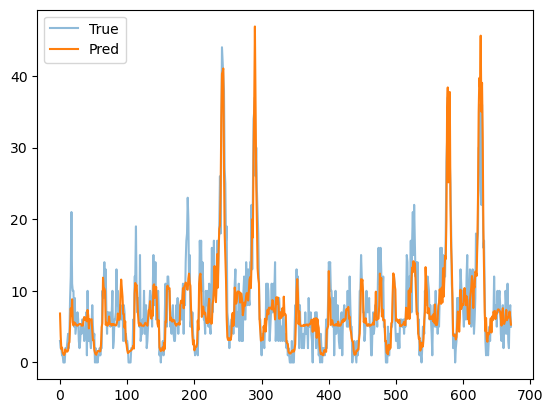

In [12]:
src, trg = next(iter(test_loader))
pred = model(src)
plt.plot(trg.cpu().numpy(), label='True', alpha=0.5)
plt.plot(pred.cpu().detach().numpy(), label='Pred')
plt.legend()
plt.show()


## Use Colab to reproduce the above code on the cloud

If you have not configured the Pytorch environment (GPU version) on your personal computer, you may not be able to run this notebook 
or it will run very slowly. \
In this case, you might consider using Colab, a free-to-use cloud server developed by the Google Research team. \
\
The use of Colab is very simple, very similar to the operation of jupyter notebook, you can find the tutorials in the following links:  \
https://www.youtube.com/watch?v=inN8seMm7UI     \
https://research.google.com/colaboratory/faq.html   \
https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c  
\
I have uploaded the data and code related to travel demand forecasting in my Google drive, \
you can directly click the link below to run the code directly on the cloud through the Colab file I shared. \
There is no need to configure any environment, but you need to have a Google account.   \
https://drive.google.com/drive/folders/1wNosCyGXx0UZ-yoiJldeHWLjpQ1n2xvi?usp=drive_link

After opening the link above, first you should right-click on the shared folder, select "Add shortcut to Drive", and then click on "My Drive" to save the shared folder to your Google Drive. Next, you should open the demo.ipynb file with Google Colaboratory to run the above code on the cloud.
